# MVA - Probabilistic Graphical Models
## DM2
#### Ariane ALIX, Hassen MIRI

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
from numpy import ndarray

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.style.use("seaborn")

from scipy.linalg import eigh
from scipy.stats import multivariate_normal as MVN

from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

## 1. K-Means and the EM algorithm

### Question 3.

#### Loading data

In [3]:
X_iris = load_iris().data
Z_iris = load_iris().target

#### Function to compute the $p(X|Z)$

In [4]:
def p_x_z(X,K, centers, covs):
    #MVN is the multivariate_normal
    
    p=[MVN.pdf(X, mean=centers[0], cov=covs[0])]
    for k in range(1,K):
        p.append(MVN.pdf(X, mean=centers[k], cov=covs[k]))
    
    return p

#### Implementation of the EM algorithm for the sparse Gaussian Mixture

In [44]:
def EM_sparse(X, K, iters = 100):

    n = X.shape[0] # number of datapoints
    d = X.shape[1] # dimension of the points
    
    ### -------------- ###
    ### Initialization ###
        
    # The q_k as zeros
    qs = np.zeros((K, n))
    
    # Identity matrices for the D_k
    covs=[np.eye(d)]
    for k in range(1,K):
        covs.append(np.eye(d))
        
        
    # Using a fit of KMeans for the mu_k and z_k
    kmeans = KMeans(n_clusters=K).fit(X)
    centers= kmeans.cluster_centers_
    labels= kmeans.labels_
    
    # Using a weighted average of the estimaed labels for the p_k
    p = np.zeros((K, 1))
    for k in range(K):
        p[k, 0] = np.sum(labels == k) / n #percentage of points estimated to be in cluster k

    
    
    ### -------------- ###
    ###  EM algortihm  ###
        
    for m in range(iters):
        ### Expectation
        
        # Conditional proba of X
        p_x_cond_z = p_x_z(X,K, centers, covs)
        
        # Computation of the q_ki following formula in Latex
        qs = p * p_x_cond_z  
        qs /= np.sum(qs, axis = 0)
        
        # Sum of the q_ki used in the estimators of the parameters
        sum_qs = np.sum(qs, axis = 1)  # weights, shape (num_class, 1)
        
        
        ### Maximization

        for k in range(K):
            # Estimators of p_k
            p[k, 0] = np.mean(qs[k])
            
            # Estimators of the centers mu_k
            centers[k][:] = X.T @ qs[k] / sum_qs[k]
            
            # Estimators of the cov matrices D_k
            sigma = np.sum(qs[k, :, None] * ((X - centers[k]) ** 2 ), axis=0) / sum_qs[k]
            covs[k]=sigma*np.eye(d)

    labels = qs.argmax(axis = 0) 
    return p, centers, covs, labels

#### Function to plot the results

In [6]:
def plot_points_ellipse(X, Z, K, centers, covs, title, ellipse=True):
    ### ---------- ###
    ### Formatting ###
    
    d=X.shape[1]
    
    # Number of pairs of dimensions
    nb_pairs= d*(d-1)/2
    
    # Formatting of the plot : subplots
    rows = int(nb_pairs/2)
    cols = 2
    figsize = (10, 15)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()
        
    # Index of the subplot to consider for a pair of dimensions
    ind_ax=0
    
    # List of colors to use for the ellipses and centers
    colors=['c','m','y','k','slategrey','royalblue']
    
    ### ------------------------------------ ###
    ### Iteration on all pairs of dimensions ###
    for pair_x in range(d):
        for pair_y in range(pair_x+1,d):
            
            # Selecting the subplot
            ax=axes[ind_ax] 
    
            # ------------------------------------
            # Plotting the points for all clusters
            for k in np.unique(Z):
                
                # Keeping only the pair of dimensions chosen 
                # for points in cluster k
                X_k = X[Z == k][:,[pair_x,pair_y]]
        
                ax.scatter(X_k[:,0],X_k[:,1], s=20,label="Cluster " +str(k+1),marker='+')

            
            # -----------------------------------------
            # Plotting the centers mu_k of the clusters
            # And the ellipses corresponding to the confidence intervals
            for k, center in enumerate(centers):
                
                # Plotting the centroids computed by the methods
                ax.scatter(center[[pair_x,pair_y]][0],center[[pair_x,pair_y]][1], s=50,color=colors[k])
                
                # Option to not compute an ellipse
                if ellipse :
                    cov = covs[k][[pair_x,pair_y],:][:,[pair_x,pair_y]]
                    
                    ### ---------------------------------------
                    ### Computing the parameters of the ellipse
                    lambd, v = eigh(cov)

                    # Choosing a standard deviation of 2 + *2 to get full width/height of ellipse
                    sig = 4 * np.sqrt(lambd)
                    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

                    # Plotting the ellipse with computed params
                    ell = Ellipse(xy=center[[pair_x,pair_y]], width=sig[0], height=sig[1],
                                  angle=angle,alpha=0.10,color=colors[k])
                    ax.add_patch(ell)
                
                
            ### ------
            ### Legend
            # Setting the legend and axis showing the dimensions
            ax.legend()
            ax.set_xlabel("Dimension "+str(pair_x))
            ax.set_ylabel("Dimension "+str(pair_y))
            
            # Changing to next subplot
            ind_ax+=1

    plt.suptitle(title,fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.show()



#### Computing the results for the 3 methods and plotting everything : K=2

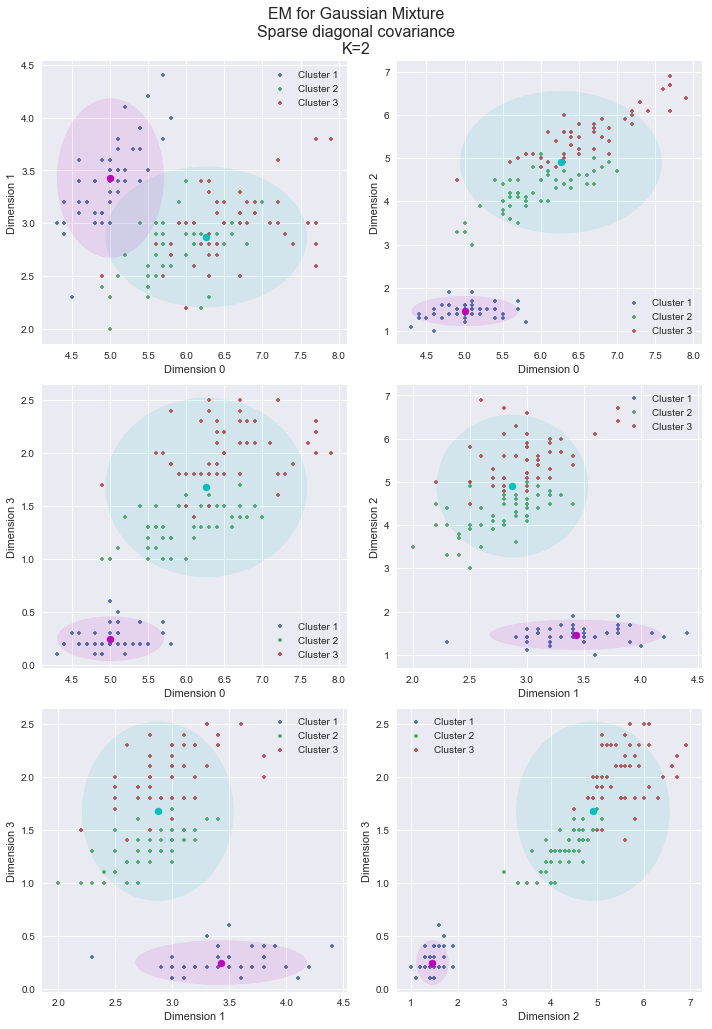

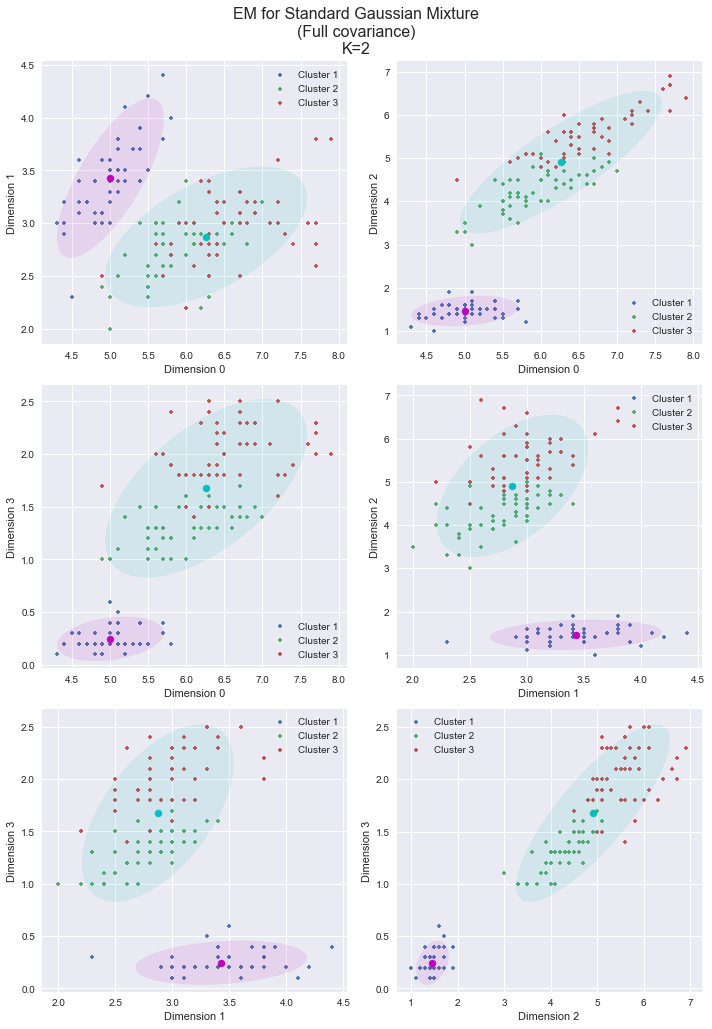

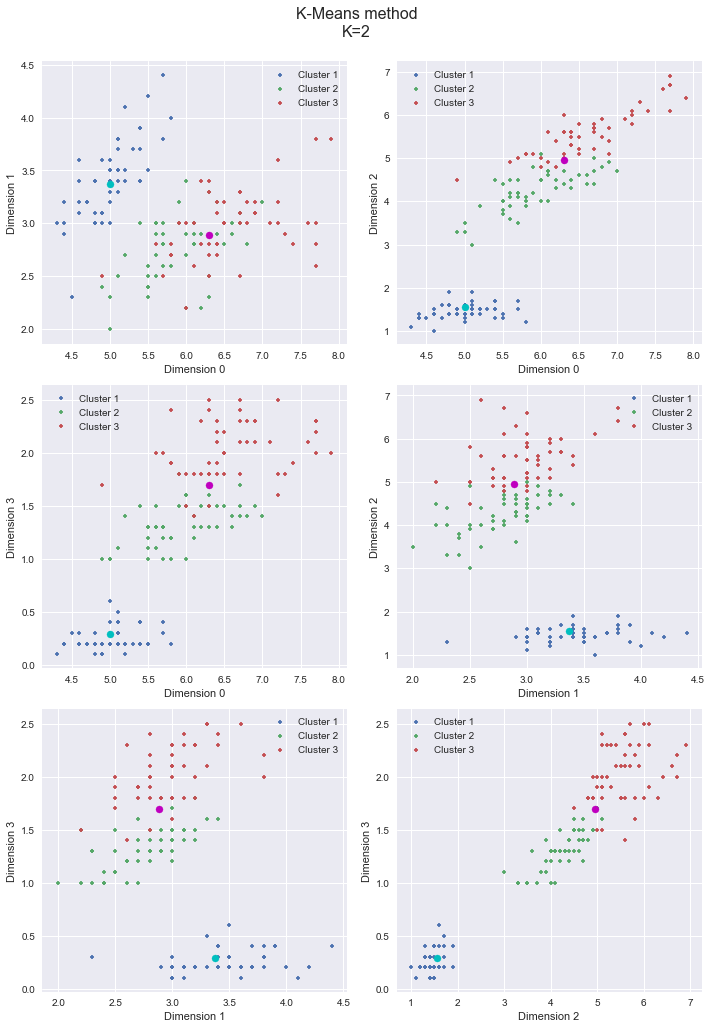

In [7]:
X=X_iris
Z=Z_iris
K=2



### ------------------------------------------------------------
### EM for Gaussian Mixture, Sparse diagonal covariance matrices
p, centers, covs, labels = EM_sparse(X, K, iters=50)
plot_points_ellipse(X, Z, K, centers, covs, "EM for Gaussian Mixture\nSparse diagonal covariance\nK=" +str(K))


### ---------------------------------------------------
### EM for Standard Gaussian Mixture\n(Full covariance)
EM_gauss_mix = GaussianMixture(n_components=K)
EM_gauss_mix.fit(X)
EM_gauss_mix.predict(X)
EM_gauss_mix_centers = EM_gauss_mix.means_
EM_gauss_mix_covs = EM_gauss_mix.covariances_
plot_points_ellipse(X, Z, K, EM_gauss_mix_centers, EM_gauss_mix_covs, "EM for Standard Gaussian Mixture\n(Full covariance)\nK=" +str(K))


### --------------------------------
### K-Means method
kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_
# No covariance matrix is returned by the K-means method, we disbale it in the plotting function
plot_points_ellipse(X, Z, K, kmeans_centers, None, "K-Means method\nK=" +str(K), ellipse=False)

#### Computing the results for the 3 methods and plotting everything : K=3

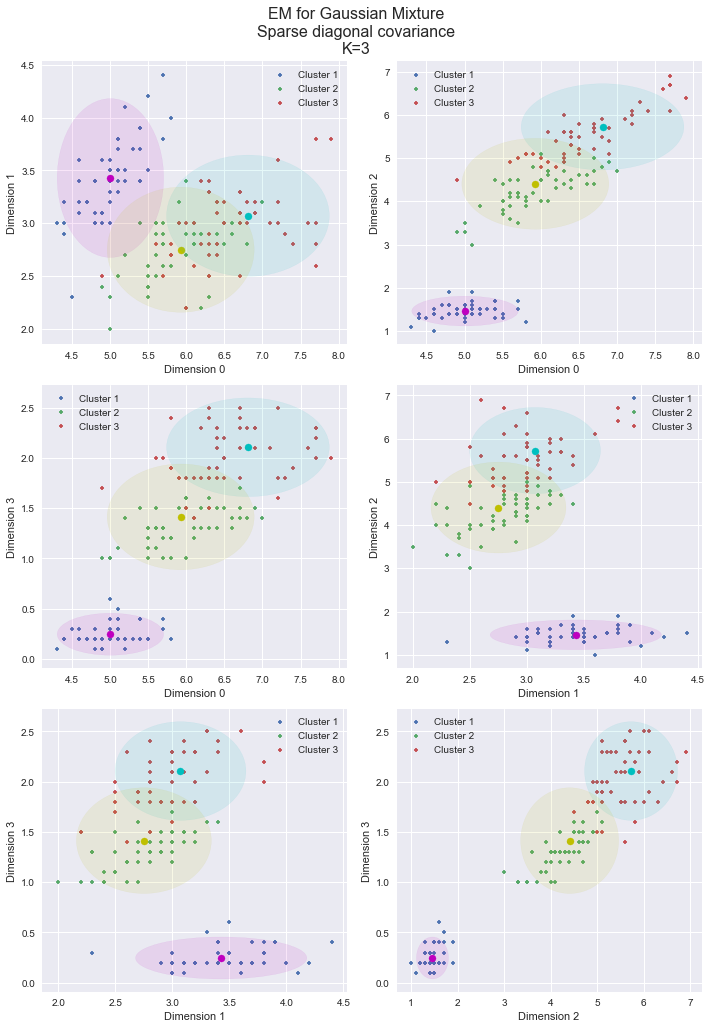

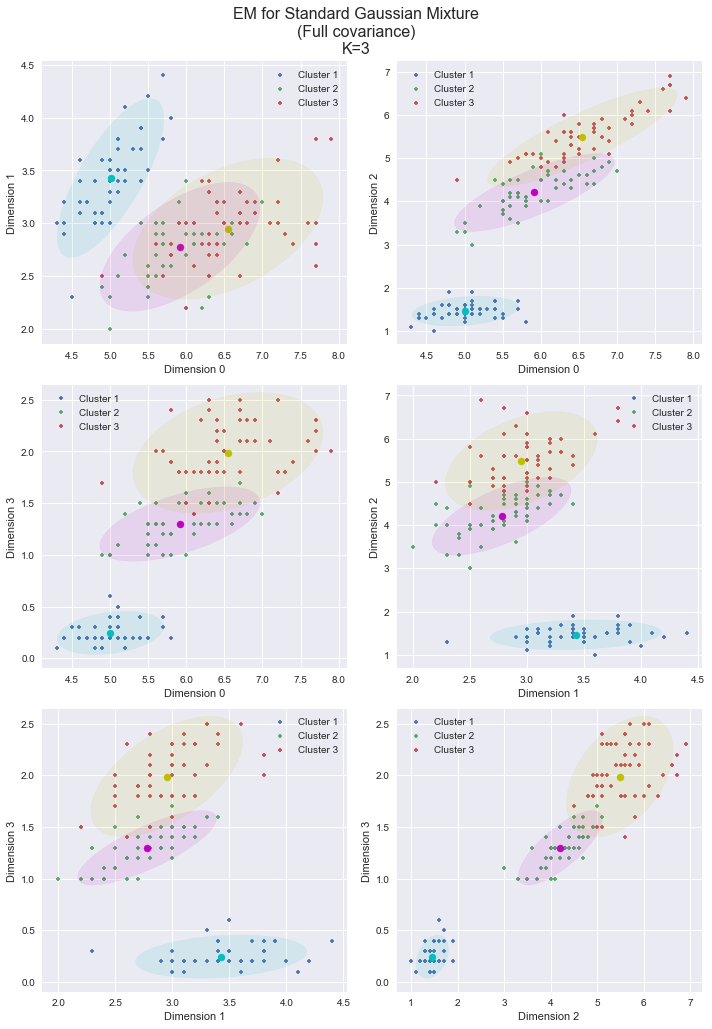

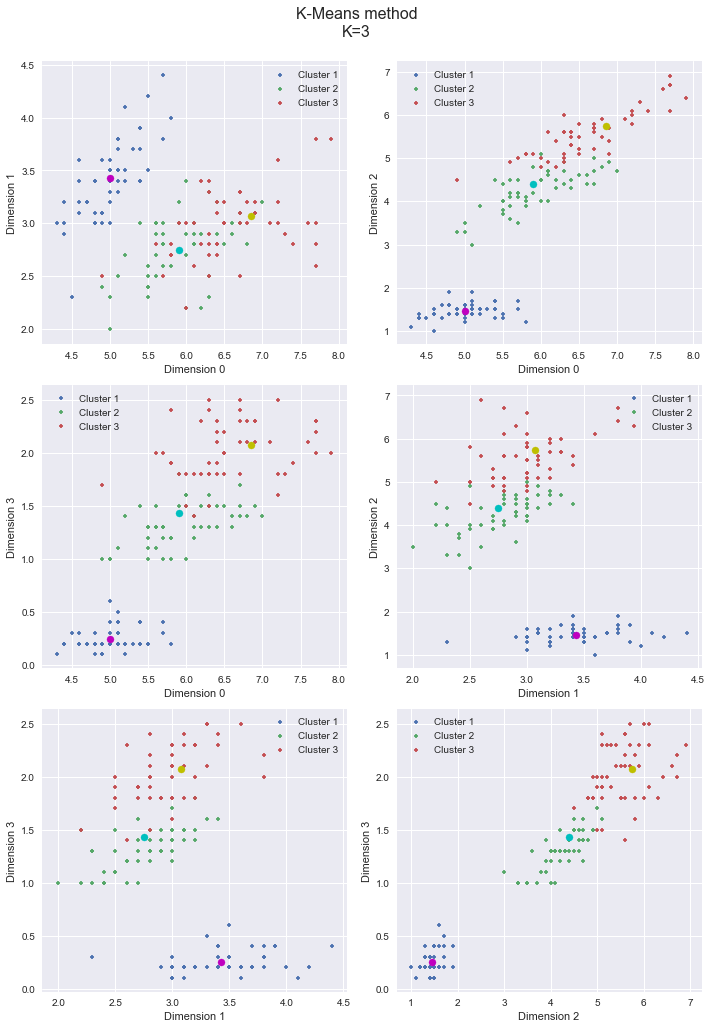

In [8]:
X=X_iris
Z=Z_iris
K=3


### ------------------------------------------------------------
### EM for Gaussian Mixture, Sparse diagonal covariance matrices
p, centers, covs, labels = EM_sparse(X, K, iters=50)
plot_points_ellipse(X, Z, K, centers, covs, "EM for Gaussian Mixture\nSparse diagonal covariance\nK=" +str(K))


### ---------------------------------------------------
### EM for Standard Gaussian Mixture\n(Full covariance)
EM_gauss_mix = GaussianMixture(n_components=K)
EM_gauss_mix.fit(X)
EM_gauss_mix.predict(X)
EM_gauss_mix_centers = EM_gauss_mix.means_
EM_gauss_mix_covs = EM_gauss_mix.covariances_
plot_points_ellipse(X, Z, K, EM_gauss_mix_centers, EM_gauss_mix_covs, "EM for Standard Gaussian Mixture\n(Full covariance)\nK=" +str(K))


### --------------------------------
### K-Means method
kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_
# No covariance matrix is returned by the K-means method, we disbale it in the plotting function
plot_points_ellipse(X, Z, K, kmeans_centers, None, "K-Means method\nK=" +str(K), ellipse=False)

#### Computing the results for the 3 methods and plotting everything : K=4

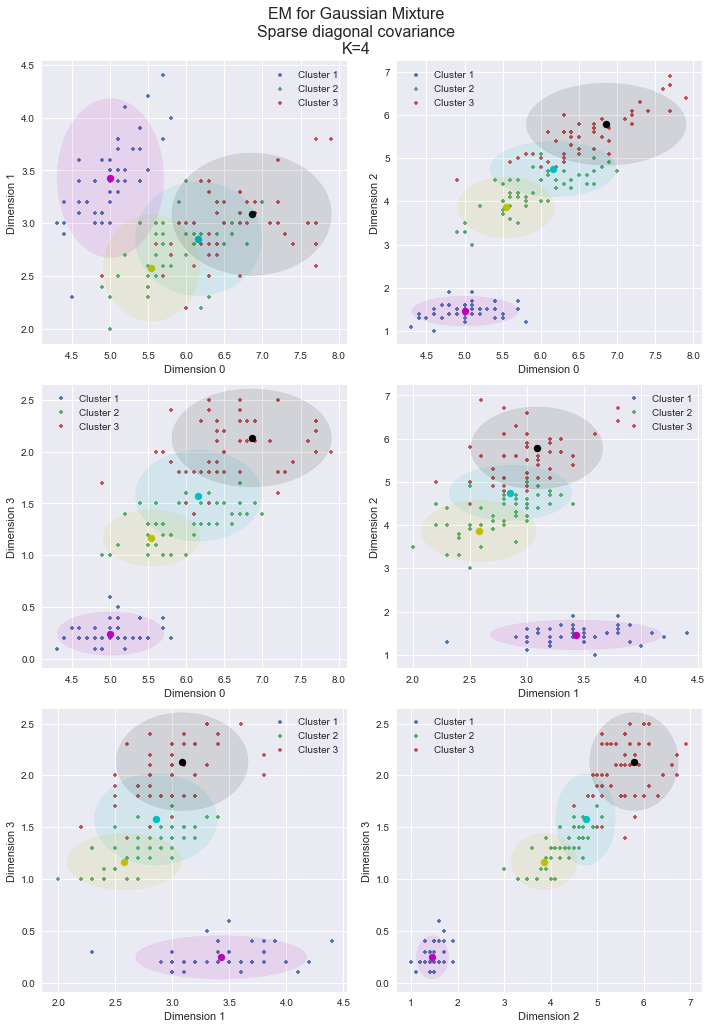

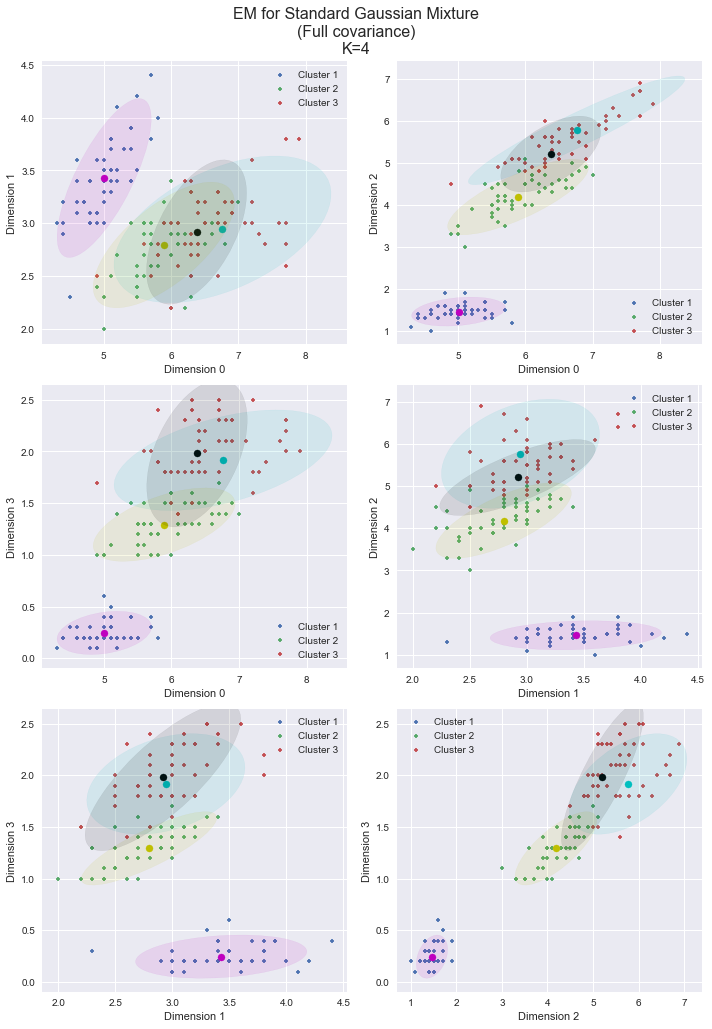

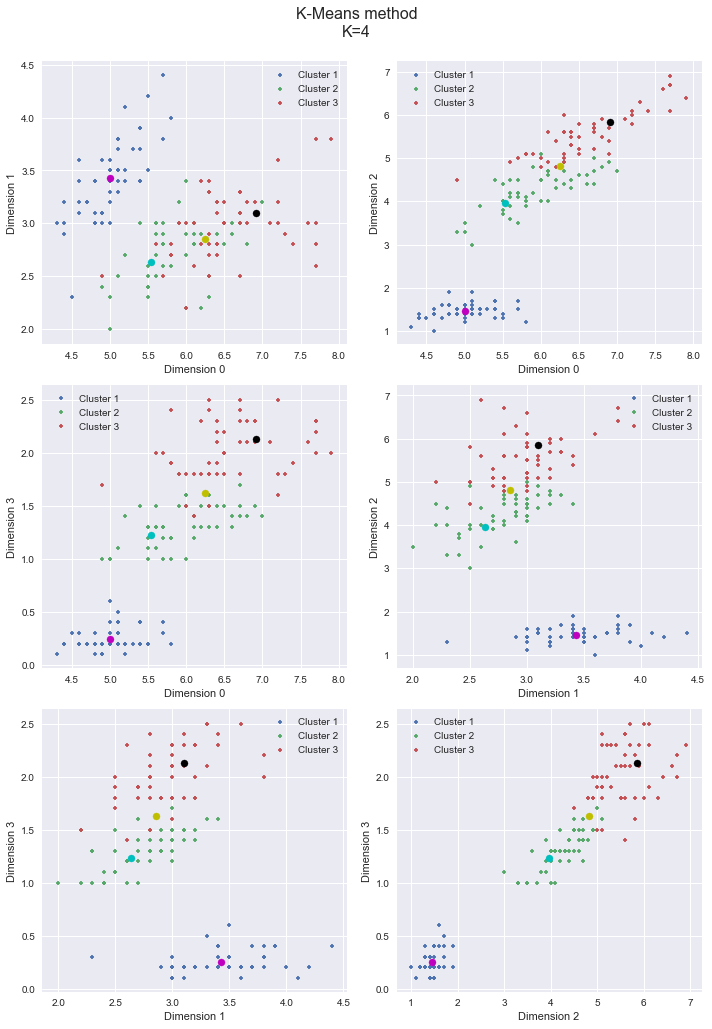

In [9]:
X=X_iris
Z=Z_iris
K=4



### ------------------------------------------------------------
### EM for Gaussian Mixture, Sparse diagonal covariance matrices
p, centers, covs, labels = EM_sparse(X, K, iters=50)
plot_points_ellipse(X, Z, K, centers, covs, "EM for Gaussian Mixture\nSparse diagonal covariance\nK=" +str(K))


### ---------------------------------------------------
### EM for Standard Gaussian Mixture\n(Full covariance)
EM_gauss_mix = GaussianMixture(n_components=K)
EM_gauss_mix.fit(X)
EM_gauss_mix.predict(X)
EM_gauss_mix_centers = EM_gauss_mix.means_
EM_gauss_mix_covs = EM_gauss_mix.covariances_
plot_points_ellipse(X, Z, K, EM_gauss_mix_centers, EM_gauss_mix_covs, "EM for Standard Gaussian Mixture\n(Full covariance)\nK=" +str(K))


### --------------------------------
### K-Means method
kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_
# No covariance matrix is returned by the K-means method, we disbale it in the plotting function
plot_points_ellipse(X, Z, K, kmeans_centers, None, "K-Means method\nK=" +str(K), ellipse=False)

### Question 4
Testing the algorithms on synthetically generated data

#### Generating the data

In [73]:
from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler

# Initizalizing seed
random_state=170

# Anisotropicly distributed data
X, Z_aniso = datasets.make_blobs(n_samples=1000, centers=3,random_state=random_state)
transformation = [[0.5, -0.7], [-0.7, 0.5]]
X_aniso = np.dot(X, transformation)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=1000,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

#### Adapted plotting function

In [59]:
def plot_points_ellipse2(X, Z, K, centers, covs, labels, title, ellipse=True):
    ### ---------- ###
    ### Formatting ###
    

    figsize = (10, 15)
    fig=plt.plot(figsize=figsize)

    # List of colors to use for the points and ellipses
    colors=['c','m','y','k','slategrey','royalblue']
    

    # ------------------------------------
    # Plotting the points for all clusters
    # with different colors for the predicted labels
    for k in np.unique(labels):

        # Keeping only the pair of dimensions chosen 
        # for points in cluster k
        X_k = X[labels == k]

        plt.scatter(X_k[:,0],X_k[:,1], s=20,label="Predicted cluster " +str(k+1),marker='+')


    # -----------------------------------------
    # Plotting the centers mu_k of the clusters
    # And the ellipses corresponding to the confidence intervals
    for k, center in enumerate(centers):

        # Plotting the centroids computed by the methods
        plt.scatter(center[0],center[1], s=50,color=colors[k])

        # Option to not compute an ellipse
        if ellipse :
            cov = covs[k]

            ### ---------------------------------------
            ### Computing the parameters of the ellipse
            lambd, v = eigh(cov)

            # Choosing a standard deviation of 2 + *2 to get full width/height of ellipse
            sig = 4 * np.sqrt(lambd)
            angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

            # Plotting the ellipse with computed params
            ax = plt.gca()
            ax.add_patch(Ellipse(xy=center, width=sig[0], height=sig[1],
                          angle=angle,alpha=0.10,color=colors[k]))


    ### ------
    ### Legend
    # Setting the legend and axis showing the dimensions
    plt.legend()

    plt.title(title,fontsize=16)
    #plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.show()

#### Anisotropic data

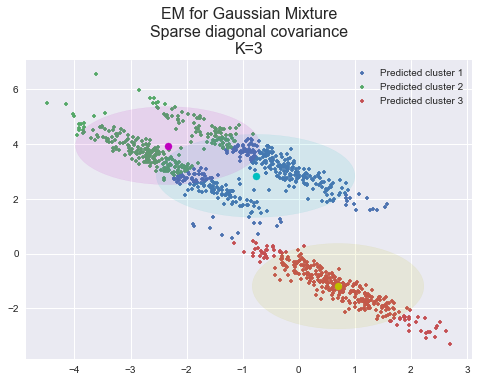

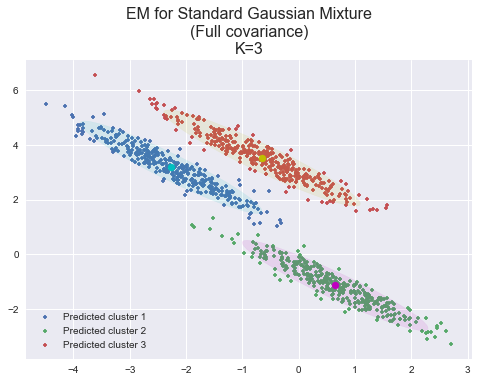

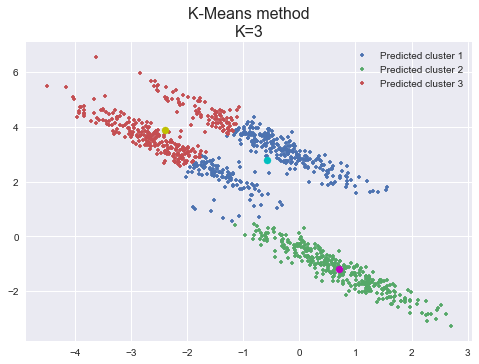

In [74]:
X=X_aniso
Z=Z_aniso
K=3

### ------------------------------------------------------------
### EM for Gaussian Mixture, Sparse diagonal covariance matrices
p, centers, covs, labels = EM_sparse(X, K, iters=50)
plot_points_ellipse2(X, Z, K, centers, covs, labels, "EM for Gaussian Mixture\nSparse diagonal covariance\nK=" +str(K))


### ---------------------------------------------------
### EM for Standard Gaussian Mixture\n(Full covariance)
EM_gauss_mix = GaussianMixture(n_components=K)
EM_gauss_mix.fit(X)
EM_gauss_mix_labels=EM_gauss_mix.predict(X)
EM_gauss_mix_centers = EM_gauss_mix.means_
EM_gauss_mix_covs = EM_gauss_mix.covariances_
plot_points_ellipse2(X, Z, K, EM_gauss_mix_centers, EM_gauss_mix_covs, EM_gauss_mix_labels,"EM for Standard Gaussian Mixture\n(Full covariance)\nK=" +str(K))


### --------------------------------
### K-Means method
kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
kmeans_labels=kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_
# No covariance matrix is returned by the K-means method, we disbale it in the plotting function
plot_points_ellipse2(X, Z, K, kmeans_centers, None, kmeans_labels,"K-Means method\nK=" +str(K), ellipse=False)

#### Blobs of varied size

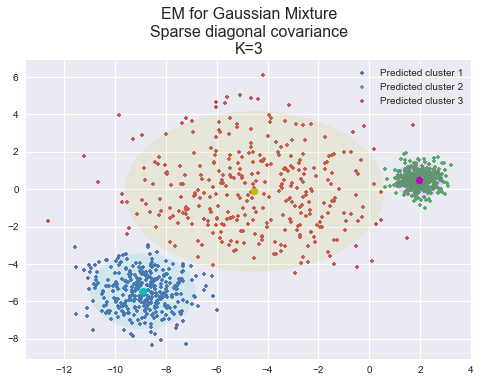

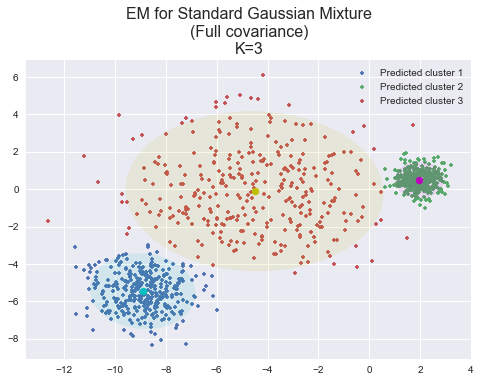

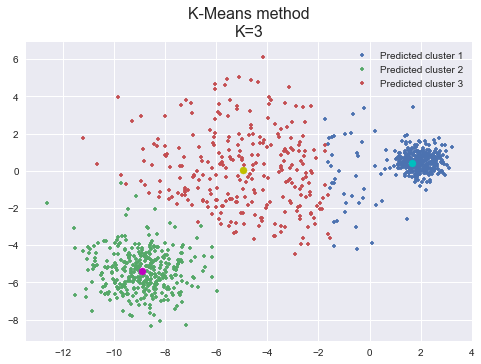

In [63]:
X=varied[0]
Z=varied[1]
K=3

### ------------------------------------------------------------
### EM for Gaussian Mixture, Sparse diagonal covariance matrices
p, centers, covs, labels = EM_sparse(X, K, iters=50)
plot_points_ellipse2(X, Z, K, centers, covs, labels, "EM for Gaussian Mixture\nSparse diagonal covariance\nK=" +str(K))


### ---------------------------------------------------
### EM for Standard Gaussian Mixture\n(Full covariance)
EM_gauss_mix = GaussianMixture(n_components=K)
EM_gauss_mix.fit(X)
EM_gauss_mix_labels=EM_gauss_mix.predict(X)
EM_gauss_mix_centers = EM_gauss_mix.means_
EM_gauss_mix_covs = EM_gauss_mix.covariances_
plot_points_ellipse2(X, Z, K, EM_gauss_mix_centers, EM_gauss_mix_covs, EM_gauss_mix_labels,"EM for Standard Gaussian Mixture\n(Full covariance)\nK=" +str(K))


### --------------------------------
### K-Means method
kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
kmeans_labels=kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_
# No covariance matrix is returned by the K-means method, we disbale it in the plotting function
plot_points_ellipse2(X, Z, K, kmeans_centers, None, kmeans_labels,"K-Means method\nK=" +str(K), ellipse=False)